In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D
from keras import regularizers
from pathlib import Path

In [3]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Рейтинги на фильмы в рассматриваемом датасете проставлены от 1 до 4 и от 7 до 10 (то есть соответствующие отрицательным отзывам и положительным, нейтральные (5 и 6) отсутствуют. Рейтинги, содержащиеся в названиях файлов исходного датасета, где каждый txt файл соответствовал одному отзыву, были для удобства записаны в общий txt файл 'rankings.txt'. Рейтингам были присвоены значения от 0 до 7, то есть рейтингу 1 соответствует лейбл 0, рейтингу 2 - 1,  3 - 2, 4 - 3, 7 - 4, 8 - 5, 9 - 6, 10 - 7.

In [4]:
# считыавние тренировоных данных (текста и рейтингов из json-файла)
texts_neg = []
with open('/content/drive/MyDrive/train_neg.txt', 'r') as f_neg:
    texts_neg = json.load(f_neg)
texts_pos = []
with open('/content/drive/MyDrive/train_pos.txt', 'r') as f_pos:
    texts_pos = json.load(f_pos)    
rankings = []
with open('/content/drive/MyDrive/rankings.txt', 'r') as f_rank:
    rankings = json.load(f_rank)

In [5]:
texts = texts_neg + texts_pos # объединение отрицательных и положительных отзывов в общий список
labels = [0 for i in range(12500)] + [1 for i in range(12500)] # создание списка меток статусов рейтингов (положительный или отрицательный)

In [6]:
# параметры для создания эмбеддингов и выборок  для тренировки и валидации
maxlen = 500 # отсечение длины отзывов после 500-го слова
vocab_size = 10000 # рассмотрение только 10000 наиболее часто используемыx слов
train_size = 15000 # размер тренировочной выборки
valid_size = 10000 # размер валидационной выборки

In [7]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts) # обучение токенайзера на корпусе отзывов
sequences = tokenizer.texts_to_sequences(texts) # векторизация токенов
data = pad_sequences(sequences, maxlen=maxlen)  # паддинг послдеовательностей 

In [8]:
# преобразование списков меток статусов и рейтингов в массивы numpy.array для удобства дельнейшего использования
labels = np.array(labels)  
rankings = np.array(rankings)

In [9]:
# перемешиваем данные перед разделением, так как отзывы упорядочуны (сначала 12500 отрицательных, затем 12500 положительных)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
rankings = rankings[indices]

In [10]:
# разделение данных на тренировочную и валидационную выборки
x_train = data[:train_size]
y_train = labels[:train_size]
y_train_rank = rankings[:train_size]
x_valid = data[train_size: train_size + valid_size]
y_valid = labels[train_size: train_size + valid_size]
y_valid_rank = rankings[train_size: train_size + valid_size]

In [12]:
cpt_pos_neg_path = "pos_neg_checkpoint.h5" # путь до чекпоинта модели, предсказывающей статус фильма (положительный или отрицательный)
cpt_rank_path = "rank_checkpoint.h5" # путь до чекпоинта модели, предсказывающей рейтинг фильма 

В основе модели для классификации отзывов на положительные и отрицательные лежат полносвязные слои, так как использование реккурентных слоёв не дало результата в улучшении качества модели, но значительно увеличило время обучения. Для снижения переобучения модели использовалось слои Dropout и L2-регуляризация.

In [ ]:
# модель, предсказывающая статус фильма
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 32)           320000    
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                      

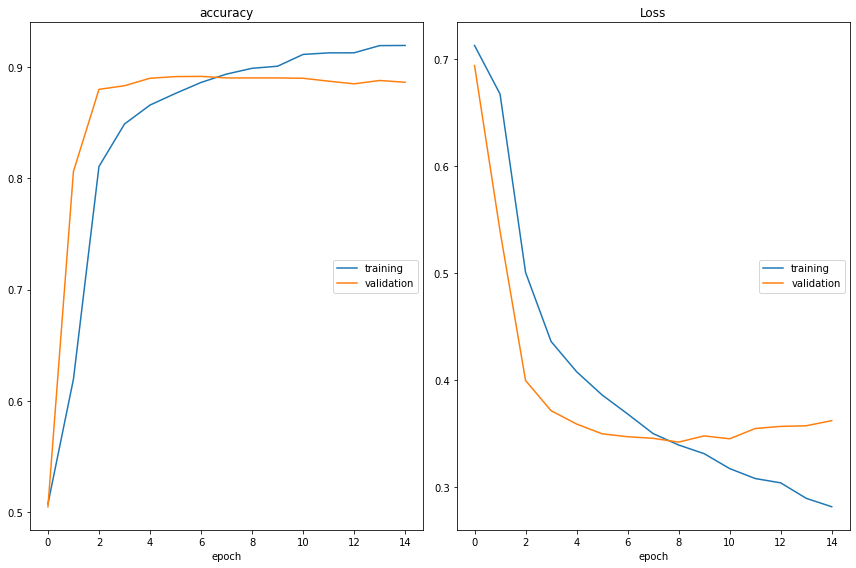

accuracy
	training         	 (min:    0.507, max:    0.920, cur:    0.920)
	validation       	 (min:    0.505, max:    0.892, cur:    0.887)
Loss
	training         	 (min:    0.281, max:    0.713, cur:    0.281)
	validation       	 (min:    0.342, max:    0.694, cur:    0.362)

Epoch 15: val_loss did not improve from 0.34183
469/469 [==============================] - 6s 12ms/step - loss: 0.2814 - accuracy: 0.9196 - val_loss: 0.3619 - val_accuracy: 0.8865


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_pos_neg_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=["accuracy"]) 
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_valid, y_valid),
                    callbacks=[PlotLossesCallback(), checkpoint])

Перед инициализацией и обучением модели, предсказывающей рейтинги, рассчитаем весовые коэффициенты каждого класса, так как в датасете явно не указано количество текстов, относящихся к каждому из классов.

In [13]:
from sklearn.utils import class_weight
classes=np.unique(y_train_rank)
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train_rank)
class_weight_dict = dict(zip(classes, class_weight))
class_weight_dict

{0: 0.6005765534913518,
 1: 1.3888888888888888,
 2: 1.3029881862404447,
 3: 1.166044776119403,
 4: 1.2729124236252545,
 5: 1.0569334836527622,
 6: 1.4129615674453655,
 7: 0.6449948400412797}

В основе модели для классификации отзывов по рейтингам также лежат полносвязные слои. Количество нейронов в каждом слое было увеличено до 32 потому, что модель не обучалась, в том числе при изменении других гиперпараметров (скорости обчения, размера батча, коэффициента прореживания и коэффициенты регуляризации). Использование большего количества нейронов в полносвязных слоях приводило к переобучению модели. Для снижения переобучения модели также использовалось слои Dropout и L2-регуляризация.

In [26]:
# модель, предсказывающей рейтинг фильма 
model_rank = Sequential()
model_rank.add(Embedding(vocab_size, 32, input_length=maxlen))
model_rank.add(GlobalAveragePooling1D())
model_rank.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_rank.add(Dropout(0.4))
model_rank.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_rank.add(Dropout(0.4))
model_rank.add(Dense(8, activation='softmax'))
model_rank.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 32)           320000    
                                                                 
 global_average_pooling1d_5   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                      

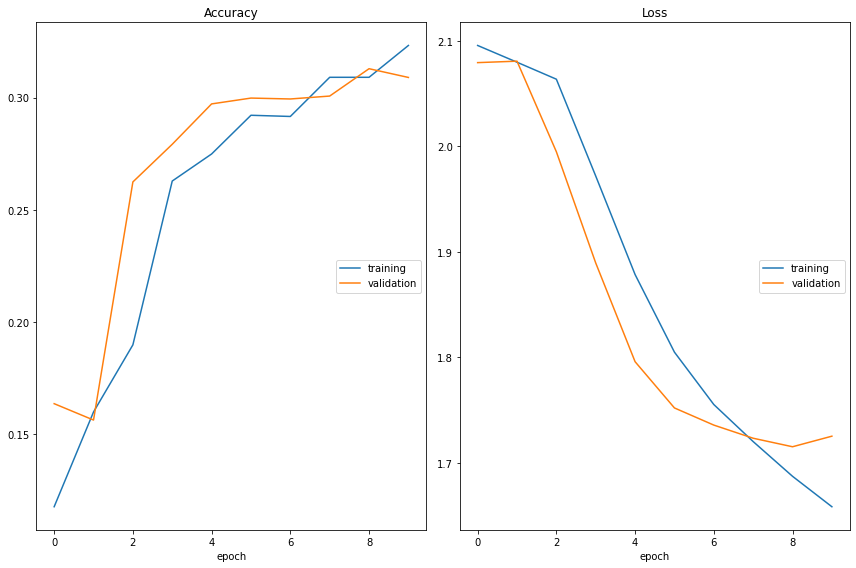

Accuracy
	training         	 (min:    0.118, max:    0.323, cur:    0.323)
	validation       	 (min:    0.156, max:    0.313, cur:    0.309)
Loss
	training         	 (min:    1.658, max:    2.096, cur:    1.658)
	validation       	 (min:    1.715, max:    2.081, cur:    1.725)

Epoch 10: val_loss did not improve from 1.71513
469/469 [==============================] - 5s 10ms/step - loss: 1.6582 - acc: 0.3233 - val_loss: 1.7252 - val_acc: 0.3090


In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_rank_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_rank.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 
history = model_rank.fit(x_train, y_train_rank,
                         epochs=10,
                         batch_size=32,
                         validation_data=(x_valid, y_valid_rank),
                         class_weight=class_weight_dict, 
                         callbacks=[PlotLossesCallback(), checkpoint])

In [11]:
# считывание тестовых данных (текста и рейтингов из json-файла)
test_texts_neg = []
with open('test_neg.txt', 'r') as f_neg:
    test_texts_neg = json.load(f_neg)
test_texts_pos = []
with open('test_pos.txt', 'r') as f_pos:
    test_texts_pos = json.load(f_pos)    
test_rankings = []
with open('rankings_test.txt', 'r') as f_rank:
    test_rankings = json.load(f_rank)

test_texts = test_texts_neg + test_texts_pos

In [12]:
sequences = tokenizer.texts_to_sequences(test_texts) # векторизация тестовых данных с помощью обученного ранее токенайзера
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)
y_test_rank = np.asarray(test_rankings)

In [35]:
# Оценка точности модели, предсказывающей статус
restored_model = load_model(cpt_pos_neg_path) 
loss, acc = restored_model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.3504 - accuracy: 0.8838


In [30]:
# Оценка точности модели, предсказывающей рейтинг
restored_model_rank = load_model(cpt_rank_path) 
loss, acc = restored_model_rank.evaluate(x_test, y_test_rank)

782/782 [==============================] - 2s 2ms/step - loss: 1.7350 - acc: 0.3068


In [36]:
# Функция predict_status_ranking получает на вход текст рейтинга, выводит статус и рейтинг
def predict_status_ranking():
    text_input = input('Enter a movie review \n')
    text_list = [0]
    text_list[0] = text_input
    text_input = text_list
    sequences = tokenizer.texts_to_sequences(text_input)
    data = pad_sequences(sequences, maxlen=maxlen)
    predicted_status = restored_model.predict(data)
    predicted_rank = restored_model_rank.predict(data)
    print('Status: ', 'positive' if predicted_status > 0.5 else 'negative')
    print('Ranking: ', (np.argmax(predicted_rank) + 1) if  np.argmax(predicted_rank) <= 3 
          else  (np.argmax(predicted_rank) + 3))  # преобразование меток классов от 0 до 7 к значениям рейтингов от 1 до 10

In [74]:
predict_status_ranking()
# отзыв 2, отрицательный, рейтинг 1

Enter a movie review 
First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like cliché'e version of gangsters.<br /><br />The movie doesn't take more than five minutes to explain what is going on before we're already at the warehouse There is not a single sympathetic character in this movie, except for the homeless guy, who is also the only one with half a brain.<br /><br />Bill Paxton and William Sadler are both hill billies and Sadlers character is just as much a villain as the gangsters. I did'nt like him right from the start.<br /><br />The movie is filled with pointless violence and Walter Hills specialty: people falling through windows with glass flying everywhere. There is pretty much no plot and it is a big problem when you root for no-one. Everybody dies, except from Paxton and the homeless guy and everybody get what they deserve.<br /><br />The only two black people 

In [50]:
predict_status_ranking()
# отзыв 24900, положительный, рейтинг 10

Enter a movie review 
This may not be the most exiting or incredible episode they\'ve made, but in my opinion it remains as one of Star Trek and the Sci-Fi genre\'s most original episodes. Most ideas from retro Sci-Fi series especially including Star Trek has been reused several times, this one the other hand remains mostly as a one time triumph. This among the episodes that impressed me the most towards the end.<br /><br />Another thing I like with this episode is how it has accomplished to create such and exiting and captivating story with such few special affects. Now without criticizing the episode I must admit the effects are very dated, but then again what can you expect from a TV show from 1967? But still the creature ("Horta") in this episode is basically just a carpet with some coloured rubber on it. Yet you forget this after about 1 minute and you only start thinking about it as what it\'s supposed to be. Also the caves don\'t exactly look like rock, but again you forget it a